In [1]:
import matplotlib

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.integrate as spint
import scipy.io as sio
from os.path import isfile, isdir

# Enable interactive figures for latest versions of Jupyter Lab, with 'jupyter-matplotlib' 'widgetsnbextension' installed and activated.
#%matplotlib widget
# If no figure is showing, replace with
%matplotlib inline

In [2]:
def lorenz(t, xyzr, s=10, b=8/3):
    x, y, z, r = xyzr
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    r_dot = 0   # rho is constant
    return x_dot, y_dot, z_dot, r_dot

In [3]:
dt = 0.01
T_end = 10

# Load pre-computed trajectories to save time
try:
    data = sio.loadmat('data/lorenz_data.mat')
    X_train = data['X_train']
    Y_train = data['Y_train']
    X_val = data['X_val']
    Y_val = data['Y_val']
    t = data['t']
    print('Lorenz trajectories imported from file')
    
# if not existing, generate new ones
except FileNotFoundError:
    N_exp = 2500    # Number of trajectories for the training set
    N_val = 500     # Number of trajectories for the validation set
    t = np.arange(0, T_end, dt)
    X_train = np.empty((4, 0))
    Y_train = np.empty((3, 0))
    X_val = np.empty((4, 0))
    Y_val = np.empty((3, 0))

    for i in range(0, N_exp + N_val):
        # Each trajectory has a random value of rho extracred from (10, 28, 40) with probabilities (0.2, 0.4, 0.4)
        rho_val = np.random.choice([10, 28, 40], p=[0.2, 0.4, 0.4])
        # Initial conditions randomly extracted from [-15, 15]^3. 
        # Rho is considered as a constant state for simplicity
        y0 = np.append(30 * (np.random.random((3,)) - 0.5), rho_val)
        # Solve Lorenz ODE
        sol = spint.solve_ivp(lorenz, y0=y0, t_span=[0, T_end], t_eval=t, atol=1e-10, rtol=1e-9)

        if i < N_exp:
            X_train = np.concatenate((X_train, sol.y[:, 0:-1]), axis=1)
            Y_train = np.concatenate((Y_train, sol.y[:-1, 1:]), axis=1)
        else:
            X_val = np.concatenate((X_val, sol.y[:, 0:-1]), axis=1)
            Y_val = np.concatenate((Y_val, sol.y[:-1, 1:]), axis=1)

    sio.savemat('data/lorenz_data.mat',
                {'X_train': X_train, 'Y_train': Y_train, 'X_val': X_val, 'Y_val': Y_val, 't': t},
                do_compression = True)
    print('Lorenz trajectories dumped to file')
    

Lorenz trajectories imported from file


In [4]:
# Standardize the trajectories for NN
# Note that the datasets contain rho as well as a constant state. It is passed as an to the NN to per form conditional learning.
norm_mean = np.mean(X_train, axis=1).reshape((4, 1))
norm_std = np.std(X_train, axis=1).reshape((4, 1))

X_train_norm = (X_train - norm_mean) / norm_std
Y_train_norm = (Y_train - norm_mean[:-1, :]) / norm_std[:-1, :]
X_val_norm = (X_val - norm_mean) / norm_std
Y_val_norm = (Y_val - norm_mean[:-1, :]) / norm_std[:-1, :]

In [5]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, LeakyReLU, Add
from tensorflow.keras.callbacks import EarlyStopping
import os
from pathlib import Path

_nn_path = str(Path('saved/trained_network_part3b'))  # This ensures robustness wrt the OS

if not tf.__version__.startswith('2'):
    tf.enable_eager_execution()

if isfile(_nn_path) or isdir(_nn_path):
    nn = tf.keras.models.load_model(_nn_path)
    print('Pre-loaded NN model imported')
else:
    class CatchUserInterruptCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if isfile('STOP.txt'):
                print('Stopping on user request...')
                self.stopped_epoch = epoch
                self.model.stop_training = True
                os.remove('STOP.txt')
    
    # A neural network with "residual" layers is introduced
    # x0 = Input(shape=(4,))
    # x1 = Dense(units=30, activation='tanh')(x0)
    # x2 = LeakyReLU(alpha=0.05)(Dense(units=30)(x1))
    # x3 = Dense(units=30, activation='tanh')(x2)
    # x4 = Add()([x1, x3])
    # x5 = LeakyReLU(alpha=0.05)(Dense(units=30)(x4))
    # x6 = Dense(units=30, activation='tanh')(x5)
    # x7 = Add()([x4, x6])
    # x8 = Dense(units=3, activation='linear')(x7)
    x0 = Input(shape=(4,))
    x0_s = x0[:,:3]
    x1 = Dense(units=30, activation='tanh')(x0)
    x2 = LeakyReLU(alpha=0.05)(Dense(units=30)(x1))
    x3 = Dense(units=30, activation='tanh')(x2)
    x4 = Dense(units=3, activation='linear')(x3)
    x5 = Add()([x4, x0_s])

    nn = Model(x0, x5)
    nn.compile(tf.keras.optimizers.Adam(1e-3), loss='mse')
    esr = EarlyStopping(monitor='val_loss', verbose=1, restore_best_weights=True, patience=100)
    nn.summary()
    nn.fit(X_train_norm.T, Y_train_norm.T, validation_data=(X_val_norm.T, Y_val_norm.T),
           epochs=2000, batch_size=1250, shuffle=True, callbacks=[CatchUserInterruptCallback(), esr])

    nn.save(_nn_path)
    print("Neural network trained and dumped to file")


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Pre-loaded NN model imported


In [6]:
# Eventually the trained network is tested on a trajectory with a novel value of rho
y0 = np.append(30 * (np.random.random((3,)) - 0.5), 17) # Rho is managed as an initial state
sol = spint.solve_ivp(lorenz, y0=y0, t_span=[0, T_end], t_eval=t.flatten(), atol=1e-10, rtol=1e-9)
sol_true = sol.y[0:3, :]
# Less-accurate ODE45 
sol = spint.solve_ivp(lorenz, y0=y0, t_span=[0, T_end], t_eval=t.flatten(), atol=1e-5, rtol=1e-4)
sol_app = sol.y[0:3, :]

x0 = (y0.reshape((4,1)) - norm_mean) / norm_std
sol_nn = np.zeros(sol_true.shape)
for i in range(0, sol_nn.shape[1]):
    x_next = nn.predict(x0.T).T
    sol_nn[:, i] = (x_next * norm_std[:-1,:] + norm_mean[:-1,:]).reshape((3,))
    x0 = np.append(x_next, x0[-1].reshape(1, 1), axis=0)

t_sol = np.linspace(0, T_end, sol_nn.shape[1])

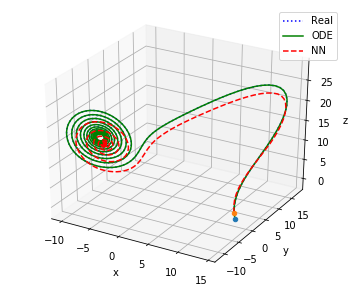

In [7]:
fig = plt.figure(figsize=(6, 5))
ax3 = plt.axes(projection='3d')
ax3.plot3D(sol_true[0, :], sol_true[1, :], sol_true[2, :], 'b:')
ax3.plot3D(sol_app[0, :], sol_app[1, :], sol_app[2, :], 'g')
ax3.plot3D(sol_nn[0, :], sol_nn[1, :], sol_nn[2, :], 'r--')
ax3.scatter3D(sol_true[0, 0], sol_true[1, 0], sol_true[2, 0])
ax3.scatter3D(sol_nn[0, 0], sol_nn[1, 0], sol_nn[2, 0])
ax3.legend(['Real', 'ODE', 'NN'])
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')

plt.savefig('figs/Lor_prediction_nn_3D_17.png')

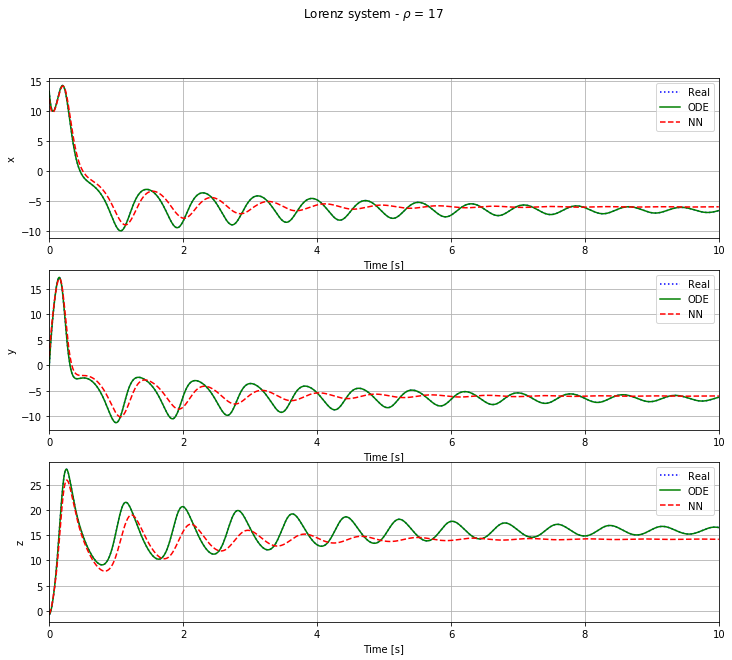

In [8]:
fig2, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(12, 10))
fig2.suptitle(r"Lorenz system - $\rho$ = 17")
ax0.plot(t_sol, sol_true[0, :], 'b:')
ax0.plot(t_sol, sol_app[0, :], 'g')
ax0.plot(t_sol, sol_nn[0, :], 'r--')
ax0.legend(["Real", "ODE", "NN"])
ax0.grid()
ax0.set_xlim((0, T_end))
ax0.set_xlabel("Time [s]")
ax0.set_ylabel("x")

ax1.plot(t_sol, sol_true[1, :], 'b:')
ax1.plot(t_sol, sol_app[1, :], 'g')
ax1.plot(t_sol, sol_nn[1, :], 'r--')
ax1.legend(["Real", "ODE", "NN"])
ax1.grid()
ax1.set_xlim((0, T_end))
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("y")

ax2.plot(t_sol, sol_true[2, :], 'b:')
ax2.plot(t_sol, sol_app[2, :], 'g')
ax2.plot(t_sol, sol_nn[2, :], 'r--')
ax2.legend(["Real", "ODE", "NN"])
ax2.grid()
ax2.set_xlim((0, T_end))
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("z")

plt.savefig('figs/Lor_nn_prediction_17.png')

In [9]:
# Eventually the trained network is tested on a trajectory with a novel value of rho
y0 = np.append(30 * (np.random.random((3,)) - 0.5), 35) # Rho is managed as an initial state
sol = spint.solve_ivp(lorenz, y0=y0, t_span=[0, T_end], t_eval=t.flatten(), atol=1e-10, rtol=1e-9)
sol_true = sol.y[0:3, :]
# Less-accurate ODE45 
sol = spint.solve_ivp(lorenz, y0=y0, t_span=[0, T_end], t_eval=t.flatten(), atol=1e-5, rtol=1e-4)
sol_app = sol.y[0:3, :]

x0 = (y0.reshape((4,1)) - norm_mean) / norm_std
sol_nn = np.zeros(sol_true.shape)
for i in range(0, sol_nn.shape[1]):
    x_next = nn.predict(x0.T).T
    sol_nn[:, i] = (x_next * norm_std[:-1,:] + norm_mean[:-1,:]).reshape((3,))
    x0 = np.append(x_next, x0[-1].reshape(1, 1), axis=0)

t_sol = np.linspace(0, T_end, sol_nn.shape[1])

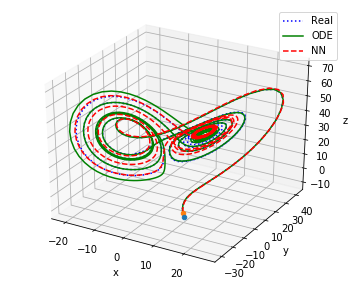

In [10]:
fig = plt.figure(figsize=(6, 5))
ax3 = plt.axes(projection='3d')
ax3.plot3D(sol_true[0, :], sol_true[1, :], sol_true[2, :], 'b:')
ax3.plot3D(sol_app[0, :], sol_app[1, :], sol_app[2, :], 'g')
ax3.plot3D(sol_nn[0, :], sol_nn[1, :], sol_nn[2, :], 'r--')
ax3.scatter3D(sol_true[0, 0], sol_true[1, 0], sol_true[2, 0])
ax3.scatter3D(sol_nn[0, 0], sol_nn[1, 0], sol_nn[2, 0])
ax3.legend(['Real', 'ODE', 'NN'])
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')

plt.savefig('figs/Lor_prediction_nn_3D_35.png')


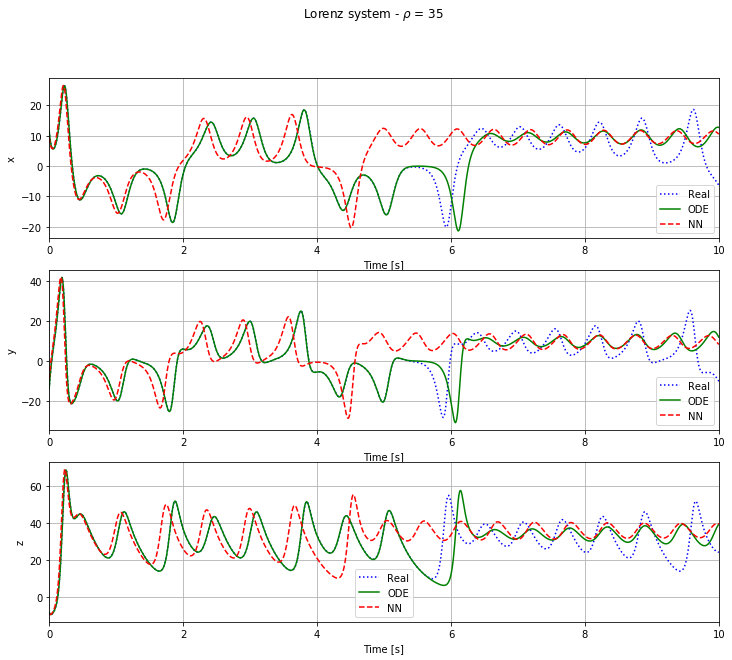

In [11]:
fig2, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(12, 10))
fig2.suptitle(r"Lorenz system - $\rho$ = 35")
ax0.plot(t_sol, sol_true[0, :], 'b:')
ax0.plot(t_sol, sol_app[0, :], 'g')
ax0.plot(t_sol, sol_nn[0, :], 'r--')
ax0.legend(["Real", "ODE", "NN"])
ax0.grid()
ax0.set_xlim((0, T_end))
ax0.set_xlabel("Time [s]")
ax0.set_ylabel("x")

ax1.plot(t_sol, sol_true[1, :], 'b:')
ax1.plot(t_sol, sol_app[1, :], 'g')
ax1.plot(t_sol, sol_nn[1, :], 'r--')
ax1.legend(["Real", "ODE", "NN"])
ax1.grid()
ax1.set_xlim((0, T_end))
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("y")

ax2.plot(t_sol, sol_true[2, :], 'b:')
ax2.plot(t_sol, sol_app[2, :], 'g')
ax2.plot(t_sol, sol_nn[2, :], 'r--')
ax2.legend(["Real", "ODE", "NN"])
ax2.grid()
ax2.set_xlim((0, T_end))
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("z")

plt.savefig('figs/Lor_nn_prediction_35.png')

In [12]:
# Eventually the trained network is tested on a trajectory with a novel value of rho
y0 = np.append(30 * (np.random.random((3,)) - 0.5), 28) # Rho is managed as an initial state
sol = spint.solve_ivp(lorenz, y0=y0, t_span=[0, T_end], t_eval=t.flatten(), atol=1e-10, rtol=1e-9)
sol_true = sol.y[0:3, :]
# Less-accurate ODE45 
sol = spint.solve_ivp(lorenz, y0=y0, t_span=[0, T_end], t_eval=t.flatten(), atol=1e-5, rtol=1e-4)
sol_app = sol.y[0:3, :]

x0 = (y0.reshape((4,1)) - norm_mean) / norm_std
sol_nn = np.zeros(sol_true.shape)
for i in range(0, sol_nn.shape[1]):
    x_next = nn.predict(x0.T).T
    sol_nn[:, i] = (x_next * norm_std[:-1,:] + norm_mean[:-1,:]).reshape((3,))
    x0 = np.append(x_next, x0[-1].reshape(1, 1), axis=0)

t_sol = np.linspace(0, T_end, sol_nn.shape[1])

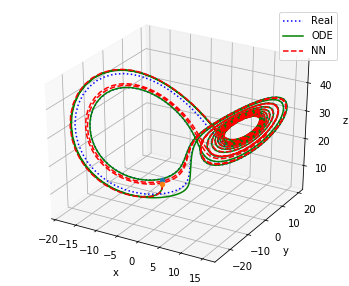

In [13]:
fig = plt.figure(figsize=(6, 5))
ax3 = plt.axes(projection='3d')
ax3.plot3D(sol_true[0, :], sol_true[1, :], sol_true[2, :], 'b:')
ax3.plot3D(sol_app[0, :], sol_app[1, :], sol_app[2, :], 'g')
ax3.plot3D(sol_nn[0, :], sol_nn[1, :], sol_nn[2, :], 'r--')
ax3.scatter3D(sol_true[0, 0], sol_true[1, 0], sol_true[2, 0])
ax3.scatter3D(sol_nn[0, 0], sol_nn[1, 0], sol_nn[2, 0])
ax3.legend(['Real', 'ODE', 'NN'])
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')

plt.savefig('figs/Lor_prediction_nn_3D_28.png')


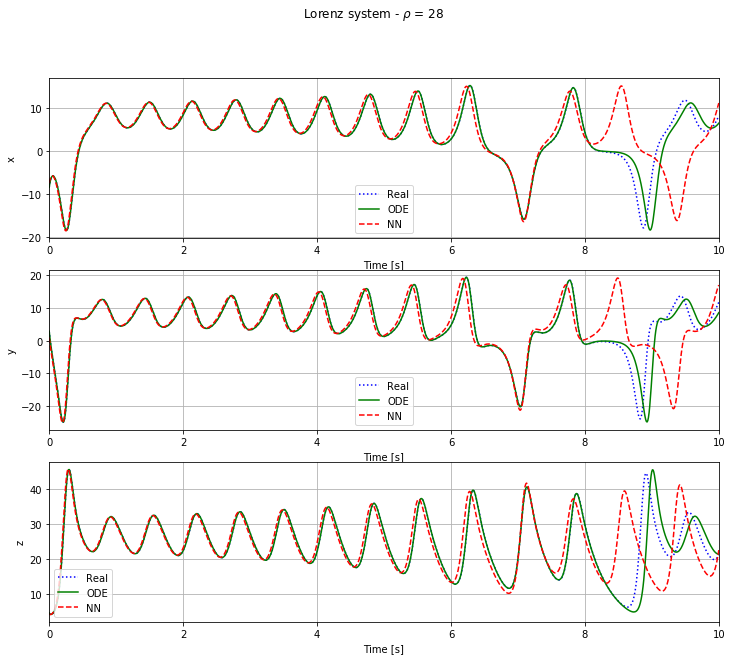

In [14]:
fig2, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(12, 10))
fig2.suptitle(r"Lorenz system - $\rho$ = 28")
ax0.plot(t_sol, sol_true[0, :], 'b:')
ax0.plot(t_sol, sol_app[0, :], 'g')
ax0.plot(t_sol, sol_nn[0, :], 'r--')
ax0.legend(["Real", "ODE", "NN"])
ax0.grid()
ax0.set_xlim((0, T_end))
ax0.set_xlabel("Time [s]")
ax0.set_ylabel("x")

ax1.plot(t_sol, sol_true[1, :], 'b:')
ax1.plot(t_sol, sol_app[1, :], 'g')
ax1.plot(t_sol, sol_nn[1, :], 'r--')
ax1.legend(["Real", "ODE", "NN"])
ax1.grid()
ax1.set_xlim((0, T_end))
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("y")

ax2.plot(t_sol, sol_true[2, :], 'b:')
ax2.plot(t_sol, sol_app[2, :], 'g')
ax2.plot(t_sol, sol_nn[2, :], 'r--')
ax2.legend(["Real", "ODE", "NN"])
ax2.grid()
ax2.set_xlim((0, T_end))
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("z")

plt.savefig('figs/Lor_nn_prediction_28.png')

In [15]:
# Eventually the trained network is tested on a trajectory with a novel value of rho
y0 = np.append(30 * (np.random.random((3,)) - 0.5), 40) # Rho is managed as an initial state
sol = spint.solve_ivp(lorenz, y0=y0, t_span=[0, T_end], t_eval=t.flatten(), atol=1e-10, rtol=1e-9)
sol_true = sol.y[0:3, :]
# Less-accurate ODE45 
sol = spint.solve_ivp(lorenz, y0=y0, t_span=[0, T_end], t_eval=t.flatten(), atol=1e-5, rtol=1e-4)
sol_app = sol.y[0:3, :]

x0 = (y0.reshape((4,1)) - norm_mean) / norm_std
sol_nn = np.zeros(sol_true.shape)
for i in range(0, sol_nn.shape[1]):
    x_next = nn.predict(x0.T).T
    sol_nn[:, i] = (x_next * norm_std[:-1,:] + norm_mean[:-1,:]).reshape((3,))
    x0 = np.append(x_next, x0[-1].reshape(1, 1), axis=0)

t_sol = np.linspace(0, T_end, sol_nn.shape[1])

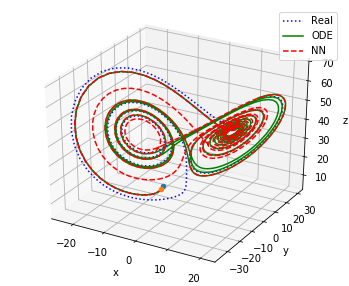

In [16]:
fig = plt.figure(figsize=(6, 5))
ax3 = plt.axes(projection='3d')
ax3.plot3D(sol_true[0, :], sol_true[1, :], sol_true[2, :], 'b:')
ax3.plot3D(sol_app[0, :], sol_app[1, :], sol_app[2, :], 'g')
ax3.plot3D(sol_nn[0, :], sol_nn[1, :], sol_nn[2, :], 'r--')
ax3.scatter3D(sol_true[0, 0], sol_true[1, 0], sol_true[2, 0])
ax3.scatter3D(sol_nn[0, 0], sol_nn[1, 0], sol_nn[2, 0])
ax3.legend(['Real', 'ODE', 'NN'])
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')

plt.savefig('figs/Lor_prediction_nn_3D_40.png')


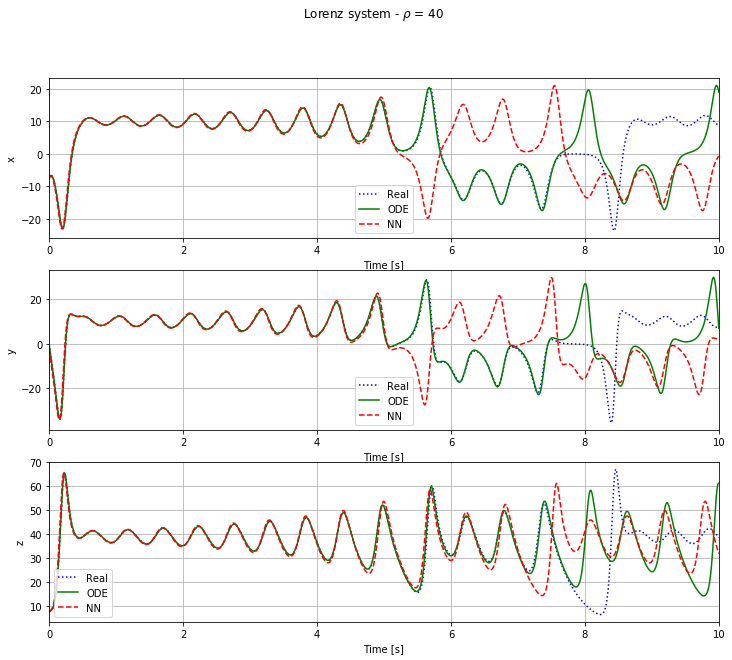

In [17]:
fig2, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(12, 10))
fig2.suptitle(r"Lorenz system - $\rho$ = 40")
ax0.plot(t_sol, sol_true[0, :], 'b:')
ax0.plot(t_sol, sol_app[0, :], 'g')
ax0.plot(t_sol, sol_nn[0, :], 'r--')
ax0.legend(["Real", "ODE", "NN"])
ax0.grid()
ax0.set_xlim((0, T_end))
ax0.set_xlabel("Time [s]")
ax0.set_ylabel("x")

ax1.plot(t_sol, sol_true[1, :], 'b:')
ax1.plot(t_sol, sol_app[1, :], 'g')
ax1.plot(t_sol, sol_nn[1, :], 'r--')
ax1.legend(["Real", "ODE", "NN"])
ax1.grid()
ax1.set_xlim((0, T_end))
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("y")

ax2.plot(t_sol, sol_true[2, :], 'b:')
ax2.plot(t_sol, sol_app[2, :], 'g')
ax2.plot(t_sol, sol_nn[2, :], 'r--')
ax2.legend(["Real", "ODE", "NN"])
ax2.grid()
ax2.set_xlim((0, T_end))
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("z")

plt.savefig('figs/Lor_nn_prediction_40.png')